## Importing libraries

In [1]:
import os
import glob
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout,Input
from tensorflow.keras.callbacks import Callback,EarlyStopping,ModelCheckpoint
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import seaborn as sns
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, Add


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
CHANNELS = 3

## loading dataset

In [3]:
img_dir = "/kaggle/input/ham1000-segmentation-and-classification/images"
mask_dir = "/kaggle/input/ham1000-segmentation-and-classification/masks"

In [4]:
def get_image_and_mask_paths(img_dir, mask_dir):
    # Get list of all image and mask files
    img_files = glob.glob(os.path.join(img_dir, '*.jpg'))
    mask_files = glob.glob(os.path.join(mask_dir, '*.png'))

    # Create a dictionary for mask paths with a key for the base filename
    mask_dict = {}
    for mask_path in mask_files:
        basename = os.path.basename(mask_path)
        # Remove '_segmentation.png' to get the corresponding image filename
        base_filename = basename.replace('_segmentation.png', '.jpg')
        mask_dict[base_filename] = mask_path

    # Create lists of (image_path, mask_path) tuples
    image_paths = []
    mask_paths = []

    for img_path in img_files:
        img_filename = os.path.basename(img_path)
        mask_path = mask_dict.get(img_filename)

        if mask_path:  # If a corresponding mask is found
            image_paths.append(img_path)
            mask_paths.append(mask_path)

    return image_paths, mask_paths


In [5]:
image_paths, mask_paths = get_image_and_mask_paths(img_dir, mask_dir)


In [6]:
# Print some sample paths
print(f"Found {len(image_paths)} image paths.")
print(f"Sample image path: {image_paths[0] if image_paths else 'No paths found'}")

print(f"Found {len(mask_paths)} mask paths.")
print(f"Sample mask path: {mask_paths[0] if mask_paths else 'No paths found'}")

Found 10015 image paths.
Sample image path: /kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0030912.jpg
Found 10015 mask paths.
Sample mask path: /kaggle/input/ham1000-segmentation-and-classification/masks/ISIC_0030912_segmentation.png


### visualize

In [7]:
def visualize_samples(image_paths, mask_paths, num_samples=5):
    num_samples = min(num_samples, len(image_paths))
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

    for i in range(num_samples):
        # Load image and mask
        img = Image.open(image_paths[i])
        mask = Image.open(mask_paths[i])

        # Convert to numpy arrays for visualization
        img_np = np.array(img)
        mask_np = np.array(mask)

        # Plot image and mask
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f"Image {i + 1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_np, cmap='gray')
        axes[i, 1].set_title(f"Mask {i + 1}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

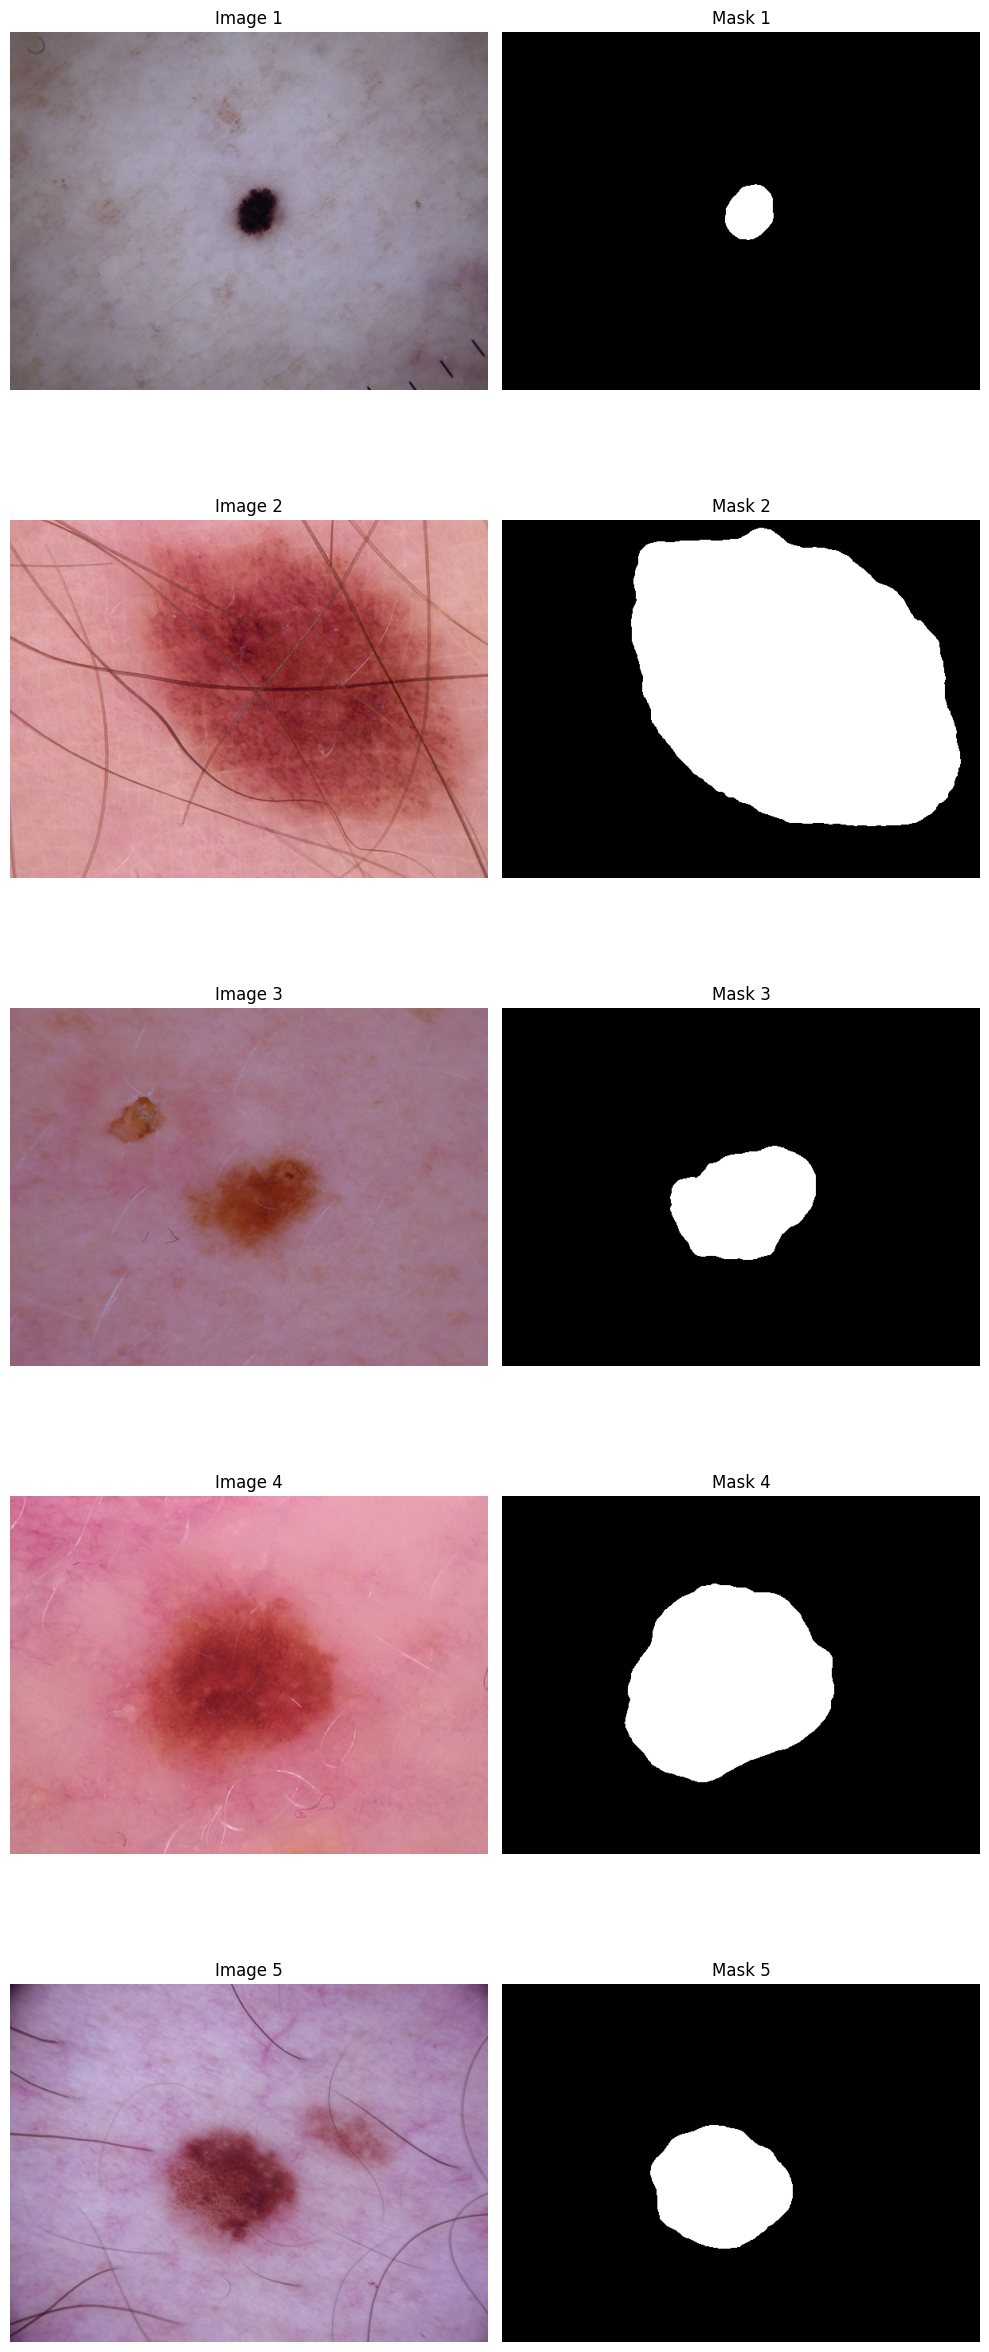

In [8]:
# Visualize samples
visualize_samples(image_paths, mask_paths, num_samples=5)

## splitting dataset

In [9]:
X = image_paths
y = mask_paths

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Then, split the train set into validation set
x_train, x_val, y_train, y_val  = train_test_split(x_train,y_train, test_size=0.2, random_state=42)


In [11]:
len(x_train), len(x_val), len(x_test)

(6409, 1603, 2003)

## preprocessing

#### resize and normalization

In [12]:
def preprocess(image_path, mask_path, img_size):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img , tf.float32) / 255.0 # Normalize
#     img = img / 255.0  

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size)
#     mask = mask / 255.0  
    mask = tf.cast(mask , tf.float32)/ 255.0 # Normalize

    return img, mask

#### data augmentation

In [13]:
def augment(img, mask):
    img = tf.image.random_flip_left_right(img,seed=123)
    mask = tf.image.random_flip_left_right(mask,seed=123)

    img = tf.image.random_flip_up_down(img,seed=123)
    mask = tf.image.random_flip_up_down(mask,seed=123)

    img = tf.image.random_hue(img, 0.1,seed=123)
    img = tf.image.random_contrast(img, 0.5, 1.5,seed=123)

    return img, mask

### apply the preprocessing

In [14]:
def create_dataset(image_paths, mask_paths, img_size, batch_size, apply_augmentation=False,is_train=False):
    # Create a TensorFlow dataset from image and mask paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    
    # Map the preprocessing function
    dataset = dataset.map(lambda img_path, mask_path: preprocess(img_path, mask_path, img_size))
    
    # Apply augmentation only for training set
    if  apply_augmentation:
        dataset = dataset.map(lambda img, mask: augment(img, mask))
    
    # Batch and shuffle (if training)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [15]:
img_size = (224,224)
train_ds = create_dataset(x_train, y_train, img_size, batch_size=32, apply_augmentation=True,is_train=True)
val_ds = create_dataset(x_val, y_val, img_size, batch_size=32,apply_augmentation=True,is_train=False)
test_ds = create_dataset(x_test, y_test, img_size, batch_size=32,apply_augmentation=False,is_train=False)

In [16]:
img_sample , mask_sample = next(iter(train_ds)) 
img_sample.shape , mask_sample.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32, 224, 224, 1]))

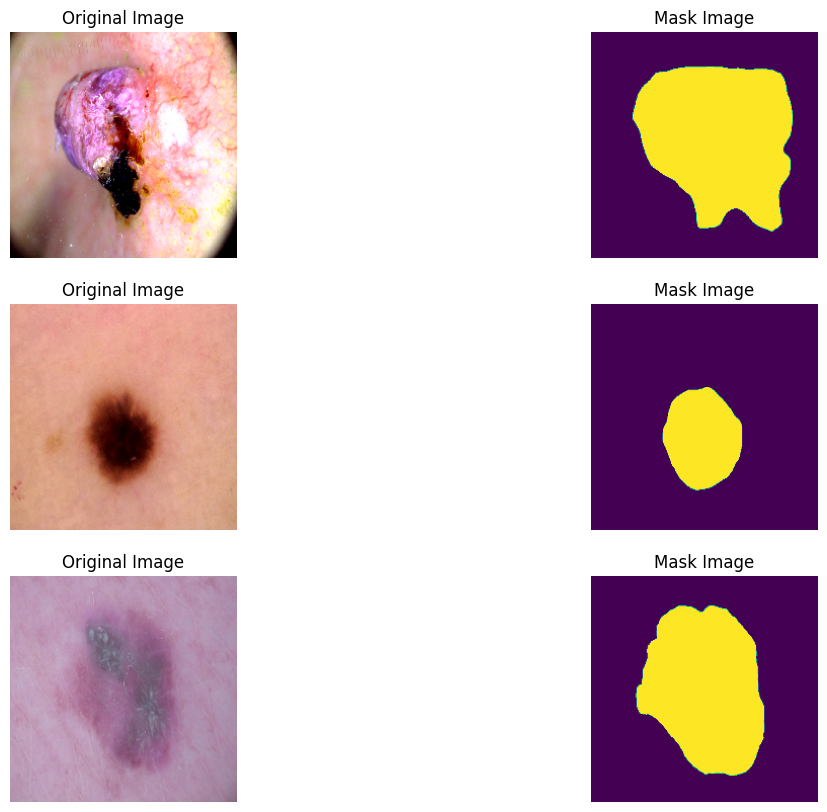

In [17]:
fig , axis = plt.subplots(3 , 2 , figsize = (15,10)) 
for i in range(3): 
    img1 = img_sample[i].numpy()
    axis[i, 0].imshow(img1)
    axis[i, 0].set(title = f"Original Image")
    axis[i, 0].axis('off')
    
    
    img2 = mask_sample[i].numpy()
    axis[i, 1].imshow(img2)
    axis[i, 1].set(title = f"Mask Image")
    axis[i, 1].axis('off')

plt.subplots_adjust(wspace=0.0)

## Modelling

In [18]:
def UNET():
    inputs = Input(shape=(224, 224, 3))
    
    # Initial Convolution Block
    x = Conv2D(32, (3, 3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Encoder Path
    # Level 1
    x1 = Conv2D(64, (3, 3), padding="same")(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)
    x1 = Conv2D(64, (3, 3), padding="same")(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)
    x1_pool = MaxPooling2D((2, 2))(x1)
    
    # Level 2
    x2 = Conv2D(128, (3, 3), padding="same")(x1_pool)
    x2 = BatchNormalization()(x2)
    x2 = Activation("relu")(x2)
    x2 = Conv2D(128, (3, 3), padding="same")(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation("relu")(x2)
    x2_pool = MaxPooling2D((2, 2))(x2)
    
    # Level 3
    x3 = Conv2D(256, (3, 3), padding="same")(x2_pool)
    x3 = BatchNormalization()(x3)
    x3 = Activation("relu")(x3)
    x3 = Conv2D(256, (3, 3), padding="same")(x3)
    x3 = BatchNormalization()(x3)
    x3 = Activation("relu")(x3)
    x3_pool = MaxPooling2D((2, 2))(x3)
    
    # Level 4
    x4 = Conv2D(512, (3, 3), padding="same")(x3_pool)
    x4 = BatchNormalization()(x4)
    x4 = Activation("relu")(x4)
    x4 = Conv2D(512, (3, 3), padding="same")(x4)
    x4 = BatchNormalization()(x4)
    x4 = Activation("relu")(x4)
    x4_pool = MaxPooling2D((2, 2))(x4)
    
    # Bottleneck
    x5 = Conv2D(1024, (3, 3), padding="same")(x4_pool)
    x5 = BatchNormalization()(x5)
    x5 = Activation("relu")(x5)
    x5 = Conv2D(1024, (3, 3), padding="same")(x5)
    x5 = BatchNormalization()(x5)
    x5 = Activation("relu")(x5)
    
    # Decoder Path
    # Level 4
    x6 = Conv2DTranspose(512, (2, 2), strides=2, padding="same")(x5)
    x6 = Add()([x6, x4])
    x6 = Conv2D(512, (3, 3), padding="same")(x6)
    x6 = BatchNormalization()(x6)
    x6 = Activation("relu")(x6)
    x6 = Conv2D(512, (3, 3), padding="same")(x6)
    x6 = BatchNormalization()(x6)
    x6 = Activation("relu")(x6)
    
    # Level 3
    x7 = Conv2DTranspose(256, (2, 2), strides=2, padding="same")(x6)
    x7 = Add()([x7, x3])
    x7 = Conv2D(256, (3, 3), padding="same")(x7)
    x7 = BatchNormalization()(x7)
    x7 = Activation("relu")(x7)
    x7 = Conv2D(256, (3, 3), padding="same")(x7)
    x7 = BatchNormalization()(x7)
    x7 = Activation("relu")(x7)
    
    # Level 2
    x8 = Conv2DTranspose(128, (2, 2), strides=2, padding="same")(x7)
    x8 = Add()([x8, x2])
    x8 = Conv2D(128, (3, 3), padding="same")(x8)
    x8 = BatchNormalization()(x8)
    x8 = Activation("relu")(x8)
    x8 = Conv2D(128, (3, 3), padding="same")(x8)
    x8 = BatchNormalization()(x8)
    x8 = Activation("relu")(x8)
    
    # Level 1
    x9 = Conv2DTranspose(64, (2, 2), strides=2, padding="same")(x8)
    x9 = Add()([x9, x1])
    x9 = Conv2D(64, (3, 3), padding="same")(x9)
    x9 = BatchNormalization()(x9)
    x9 = Activation("relu")(x9)
    x9 = Conv2D(64, (3, 3), padding="same")(x9)
    x9 = BatchNormalization()(x9)
    x9 = Activation("relu")(x9)
    
    # Output Layer
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(x9)
    
    model = Model(inputs, outputs)
    
    return model


In [19]:
model=UNET()

In [20]:
#model.summary()

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, beta_1=0.9, beta_2=0.999), 
              loss='binary_crossentropy', 
              metrics=['accuracy']
             )

In [22]:
history = model.fit(
        train_ds,
        validation_data = val_ds,
        epochs = 10         
    )

Epoch 1/10


I0000 00:00:1725142234.746597     836 service.cc:145] XLA service 0x7c6ba8001870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725142234.746662     836 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725142234.746668     836 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725142305.568547     836 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


201/201 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.7532 - loss: 0.5128 - val_accuracy: 0.7751 - val_loss: 0.4640
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.9297 - loss: 0.2252 - val_accuracy: 0.8945 - val_loss: 0.3048
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.9380 - loss: 0.1862 - val_accuracy: 0.9438 - val_loss: 0.1788
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.9435 - loss: 0.1648 - val_accuracy: 0.9489 - val_loss: 0.1539
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.9459 - loss: 0.1545 - val_accuracy: 0.9491 - val_loss: 0.1476
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.9489 - loss: 0.1451 - val_accuracy: 0.9502 - val_loss: 0.1387
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.9521 - loss: 0.1355 - val_accuracy: 0.9527 - val_loss: 0.1345
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.9526 - loss: 0.1326 - val_accuracy: 0.952

## evaluation

In [31]:
# Assuming your model is compiled with a loss function and metrics
loss,accuracy = model.evaluate(test_ds)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.9543 - loss: 0.1279
Loss: 0.13638928532600403
Accuracy: 0.9508340954780579


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


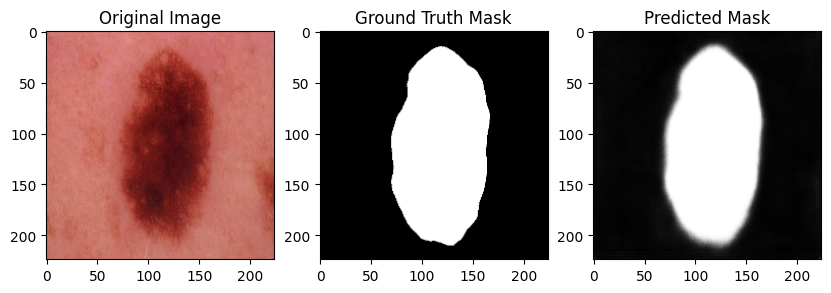

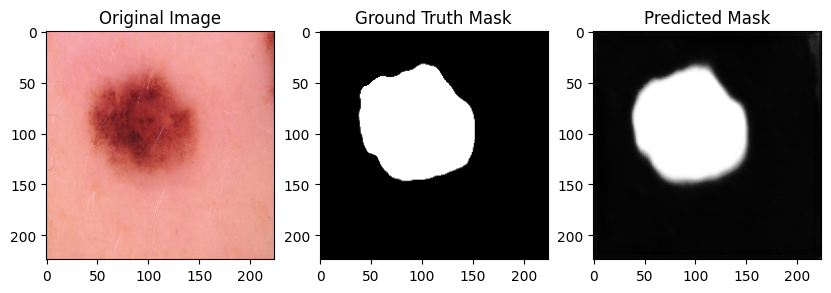

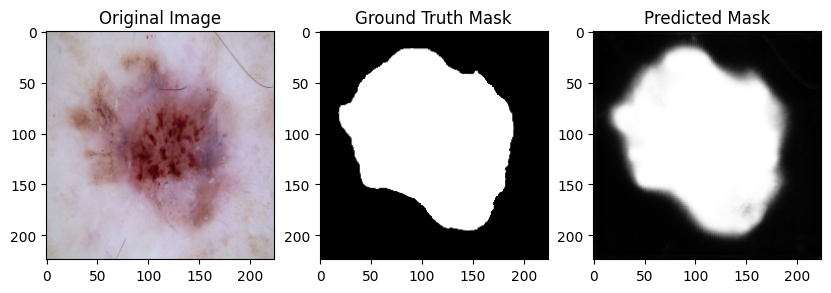

In [32]:
for image_batch, mask_batch in test_ds.take(1):
    predictions = model.predict(image_batch)  # Get model predictions

    # Visualize a few examples
    for i in range(3):  # Show 3 examples
        plt.figure(figsize=(10, 10))

        # original image
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(image_batch[i])

        # truth mask
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask_batch[i].numpy().squeeze(), cmap="gray")

        # predicted mask
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(predictions[i].squeeze(), cmap="gray")

        plt.show()


### IoU (Intersection over Union)

In [33]:
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binarize predictions
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / union
    return iou

# Evaluate IoU for each image in the test dataset
iou_scores = []
for image_batch, mask_batch in test_ds:
    predictions = model.predict(image_batch)
    iou = iou_metric(mask_batch, predictions)
    iou_scores.append(iou.numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

In [34]:
average_iou = np.mean(iou_scores)
print(f"Average IoU on Test Dataset: {average_iou}")

Average IoU on Test Dataset: 0.8365441560745239


This indicates that, on average, 83.65% of the area predicted by your model overlaps with the actual ground truth area